# CLASSIFICATION DES MALADIES DES FEVES DE CACAO EN UTILISANT LES ALGORITHMES CONVNEXT ET SVM 

## I-Chargement des données

In [ ]:
import os
import cv2
import glob
import hashlib

list_disease = ["Sana", "Fito", "Monilia"]
for disease in list_disease:
    # Chemins d'accès
    images_dir = f"Cocoa/{disease}"  # Dossier contenant les images et les annotations
    output_dir = f"InterestData/"  # Dossier de sortie

    # Crée le dossier de sortie s'il n'existe pas
    os.makedirs(output_dir, exist_ok=True)

    # Récupère tous les fichiers JPEG
    image_files = glob.glob(os.path.join(images_dir, "*.jpg"))

    for image_path in image_files:
        # Récupère le nom de base (sans extension)
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        annotation_path = os.path.join(images_dir, base_name + ".txt")

        # Charge l'image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Erreur de chargement de l'image {image_path}")
            continue

        height, width = img.shape[:2]

        # Vérifie l'existence du fichier d'annotation correspondant
        if not os.path.exists(annotation_path):
            print(f"Aucune annotation pour {image_path}")
            continue

        with open(annotation_path, "r") as f:
            lines = f.readlines()

        # Pour chaque ligne (chaque bounding box)
        for idx, line in enumerate(lines):
            line = line.strip()
            if not line:
                continue

            # Format attendu : class x_center y_center width height (valeurs normalisées)
            parts = line.split()
            if len(parts) != 5:
                print(f"Format incorrect dans {annotation_path}: {line}")
                continue

            class_id = parts[0]  # Utilisé pour nommer le fichier
            x_center_norm, y_center_norm, width_norm, height_norm = map(float, parts[1:])

            # Conversion en coordonnées absolues
            x_center = x_center_norm * width
            y_center = y_center_norm * height
            box_width = width_norm * width
            box_height = height_norm * height

            # Calcul des coordonnées (en veillant à rester dans l'image)
            x_min = int(max(x_center - box_width / 2, 0))
            y_min = int(max(y_center - box_height / 2, 0))
            x_max = int(min(x_center + box_width / 2, width))
            y_max = int(min(y_center + box_height / 2, height))

            # Extraction de la région d'intérêt
            roi = img[y_min:y_max, x_min:x_max]

            # Génération d'un identifiant unique
            hash_object = hashlib.md5(f"{base_name}_class{class_id}_roi{idx}".encode())
            identifiant = hash_object.hexdigest()[:8]  # 8 premiers caractères du hash

            # Sauvegarde de la ROI avec un nom unique
            output_filename = f"class{class_id}_{identifiant}.jpg"
            output_path = os.path.join(output_dir, output_filename)
            cv2.imwrite(output_path, roi)

            print(f"ROI enregistrée: {output_path}")


## II-Repartition des données en train et validation

In [ ]:
import os
import shutil
import random

random.seed(42)

# Configuration
source_dir = "InterestData"

train_dir = "Dataset/train"
val_dir = "Dataset/validation"
split_ratio = 0.8  # 80% train / 20% validation

# Création des répertoires
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Dictionnaire pour regrouper les fichiers par classe
class_files = {}

# Remplir le dictionnaire avec les fichiers classés par classe
for filename in os.listdir(source_dir):
    if filename.endswith(".jpg"):
        try:
            class_id = filename.split("_")[0][5:]  # Extraction du class_id
            class_files.setdefault(class_id, []).append(filename)
        except:
            print(f"Format invalide pour {filename}")
            continue

# Répartition stratifiée
for class_id, files in class_files.items():
    random.shuffle(files)  # Mélange aléatoire
    split_idx = int(len(files) * split_ratio)
    
    # Déplacement vers train
    for file in files[:split_idx]:
        src = os.path.join(source_dir, file)
        dst = os.path.join(train_dir, file)
        shutil.move(src, dst)
    
    # Déplacement vers validation
    for file in files[split_idx:]:
        src = os.path.join(source_dir, file)
        dst = os.path.join(val_dir, file)
        shutil.move(src, dst)

print(f"Répartition terminée :")
print(f"- Train: {len(os.listdir(train_dir))} images")
print(f"- Validation: {len(os.listdir(val_dir))} images")

## III-IMPLEMENTATION CONVNEXT 

In [ ]:
import tensorflow as tf
random.seed(42)

# Paramètres
batch_size = 32
img_size = (224, 224)
num_classes = 3  # Adapté à vos 3 maladies

# Fonctions utilitaires pour le pipeline

def parse_image(filename):
    """Lit et redimensionne l'image."""
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.resize(image, img_size)
    # Prétraitement spécifique à ConvNeXtSmall
    image = tf.keras.applications.convnext.preprocess_input(image)
    return image

def get_label_from_filename(filename):
    """
    Extrait le label à partir du nom du fichier.
    Format attendu : "class{id_class}_{unique_id}.jpg"
    """
    # Extraire le nom de fichier (sans chemin)
    fname = tf.strings.split(filename, os.sep)[-1]
    # Retirer le préfixe "class" et récupérer la partie avant le premier underscore
    label_str = tf.strings.regex_replace(fname, "^class", "")
    label_str = tf.strings.split(label_str, "_")[0]
    # Convertir en entier
    label = tf.strings.to_number(label_str, out_type=tf.int32)
    return label

def load_and_preprocess_image(filename):
    """Charge l'image et extrait le label one-hot."""
    image = parse_image(filename)
    label = get_label_from_filename(filename)
    # Encodage one-hot pour num_classes classes
    label = tf.one_hot(label, depth=num_classes)
    return image, label

# Création des datasets pour "train" et "test"
train_files = tf.data.Dataset.list_files("Dataset/train/*.jpg", shuffle=True)
test_files  = tf.data.Dataset.list_files("Dataset/validation/*.jpg", shuffle=False)

train_ds = train_files.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds  = test_files.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Regroupement en batches et optimisation par prefetch
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

### 1-Création du modèle ConvNeXtSmall

In [ ]:
# -------------------------------------------
# Construction du modèle avec ConvNeXtSmall
# -------------------------------------------

# Charger la base pré-entraînée ConvNeXtSmall sans la tête (include_top=False)
base_model = tf.keras.applications.ConvNeXtSmall(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size[0], img_size[1], 3)
)

# Gel initial de la base pour entraîner uniquement la tête de classification
base_model.trainable = False

# Construction de la tête de classification
inputs = tf.keras.Input(shape=(img_size[0], img_size[1], 3))
x = base_model(inputs, training=False)  # On passe training=False pour un comportement stable
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

# Compilation du modèle pour l'entraînement initial
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

#### Entraînement initial et Fine-tuning

In [ ]:
# -------------------------------------------
# Étape 2 et 3 : Entraînement initial et Fine-tuning
# -------------------------------------------

# Entraînement initial (seulement la nouvelle tête)
initial_epochs = 20
history = model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=test_ds
)

# Fine-tuning : dégeler partiellement la base
base_model.trainable = True
# Par exemple, dégeler seulement les 20% dernières couches
fine_tune_at = int(len(base_model.layers) * 0.8)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompiler le modèle avec un taux d'apprentissage réduit
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

fine_tune_epochs = 30
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=initial_epochs,
    validation_data=test_ds
)

In [ ]:
#model = tf.keras.models.load_model("Model/modele_convnext_small_mine_tf(e50).keras")

#### Evaluation du modèle

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prédire sur l'ensemble de test
y_pred_prob = model.predict(test_ds)  # Shape: (nb_exemples, num_classes)
y_pred = np.argmax(y_pred_prob, axis=1)

# 2. Extraire les vraies étiquettes à partir du dataset test
y_true = []
for images, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
y_true = np.array(y_true)

# 3. Calculer et afficher le rapport de classification
target_names = ["class0", "class1", "class2"]
report = classification_report(y_true, y_pred, target_names=target_names)
print(report)

# 4. Calculer la matrice de confusion et l'afficher graphiquement


# Calculer la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Calculer les pourcentages par classe réelle (normalisation par ligne)
cm_sum = cm.sum(axis=1, keepdims=True)
cm_perc = (cm / cm_sum.astype(float)) * 100

# Créer une matrice d'annotations combinant compte et pourcentage
labels = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        labels[i, j] = f"{cm[i,j]}\n({cm_perc[i,j]:.1f}%)"

# Afficher la heatmap avec les annotations
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=labels, fmt="", cmap="Blues")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion modèle SVM")
plt.savefig("svg/ConfusionMatrix.svg", format="svg")
plt.show()

In [ ]:
"""import pickle

with open('Model/history(e50).pkl', 'wb') as f:
    pickle.dump(history.history, f)

with open('Model/history_fine(e50).pkl', 'wb') as f:
    pickle.dump(history_fine.history, f)

# Sauvegarde au format SavedModel (par défaut)
model.save("Model/modele_convnext_small_mine_tf(e50).keras") """

In [ ]:
import pickle
import matplotlib.pyplot as plt

"""
# Charger l'historique d'entraînement
with open('Model/history.pkl', 'rb') as f:
    history = pickle.load(f)

with open('Model/history_fine.pkl', 'rb') as f:
    history_fine = pickle.load(f)
"""

# Fusionner les historiques (entraînement initial + fine-tuning)
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']
precision = history.history['precision'] + history_fine.history['precision_1']
val_precision = history.history['val_precision'] + history_fine.history['val_precision_1']
recall = history.history['recall'] + history_fine.history['recall_1']
val_recall = history.history['val_recall'] + history_fine.history['val_recall_1']


epochs_range = range(len(acc))
initial_epochs = len(history.history['accuracy'])


In [ ]:
import os
import matplotlib.pyplot as plt

# Création du dossier s'il n'existe pas
output_dir = "svg"
os.makedirs(output_dir, exist_ok=True)

# Fonction pour sauvegarder et afficher une figure
def save_and_show_plot(x, y_train, y_val, title, ylabel, filename):
    plt.figure(figsize=(7, 5))
    plt.plot(x, y_train, label="Training " + ylabel)
    plt.plot(x, y_val, label="Validation " + ylabel)
    plt.axvline(x=initial_epochs-1, color='r', linestyle='--', label="Début Fine-Tuning")
    plt.legend()
    plt.title(title)
    plt.xlabel("Époques")
    plt.ylabel(ylabel)

    # Sauvegarde en SVG
    path = os.path.join(output_dir, filename)
    plt.savefig(path, format="svg")
    print(f"Graphique sauvegardé : {path}")

    # Affichage
    plt.show()

# Sauvegarder et afficher chaque courbe individuellement
save_and_show_plot(epochs_range, acc, val_acc, "Courbe d'Accuracy", "Accuracy", "accuracy.svg")
save_and_show_plot(epochs_range, loss, val_loss, "Courbe de Perte", "Loss", "loss.svg")
save_and_show_plot(epochs_range, precision, val_precision, "Courbe de Précision", "Precision", "precision.svg")
save_and_show_plot(epochs_range, recall, val_recall, "Courbe de Rappel (Recall)", "Recall", "recall.svg")


In [ ]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Prédictions sous forme de probabilités
y_scores = model.predict(test_ds)
y_true = np.array(y_true)  # Convertir en array numpy

# Tracer la courbe ROC pour chaque classe
plt.figure(figsize=(8, 6))
colors = cycle(["blue", "red", "green"])
for i, color in zip(range(num_classes), colors):
    fpr, tpr, _ = roc_curve(y_true == i, y_scores[:, i])  # Calcul du FPR et TPR
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label=f"Classe {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")  # Ligne de référence
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbes ROC par classe")
plt.legend(loc="lower right")
# Sauvegarde en SVG
path = os.path.join(output_dir, "ROC-AUC.svg")
plt.savefig(path, format="svg")
plt.show()


### Visualisation des erreurs de classification avec ConvNext 

In [ ]:
import glob

# Récupération de tous les fichiers .jpg du dossier validation
file_paths = glob.glob("Dataset/validation/*.jpg")

# Optionnel : trier la liste pour avoir un ordre constant
# file_paths.sort()

print("Nombre d'images dans validation :", len(file_paths))
print(file_paths[:5])


In [ ]:
# Exemple de DataFrame regroupant les informations
import pandas as pd
df_errors = pd.DataFrame({
    "file_path": file_paths,
    "true_label": y_true,
    "pred_label": y_pred,
    "confidence": np.max(y_pred_prob, axis=1)
})

# Filtrer les exemples mal classés
df_errors = df_errors[df_errors["true_label"] != df_errors["pred_label"]]
print("Nombre d'erreurs :", len(df_errors))
print(df_errors.head())

# visualiser certaines images mal classées
import cv2

for idx, row in df_errors.head(2).iterrows():
    img = cv2.imread(row["file_path"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Vrai: {target_names[int(row['true_label'])]} - Prédit: {target_names[int(row['pred_label'])]}, Confiance: {row['confidence']:.2f}")
    plt.axis('off')
    plt.show()

### 2-Création du modèle ConvNext(ConvNeXtSmall) + SVM 

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.convnext import ConvNeXtSmall, preprocess_input

# Fonction pour charger les images et extraire les labels à partir du nom
def load_images_and_labels(directory, target_size=(224, 224)):
    img_list = []
    labels = []
    for file_name in os.listdir(directory):
        if file_name.lower().endswith('.jpg'):
            # Extraction du label à partir du nom de fichier
            # Format attendu : "class{id_class}_{unique_id}.jpg"
            base_name = os.path.splitext(file_name)[0]  # retire l'extension
            # Par exemple, "class0_12345" -> on récupère la première partie avant le '_'
            label_str = base_name.split('_')[0]
            # Extraire l'id de classe en retirant le préfixe "class"
            label = int(label_str.replace("class", ""))
            labels.append(label)
            
            # Chargement et prétraitement de l'image
            img_path = os.path.join(directory, file_name)
            img = image.load_img(img_path, target_size=target_size)
            img_array = image.img_to_array(img)
            img_array = preprocess_input(img_array)
            img_list.append(img_array)
    return np.array(img_list), np.array(labels)

# Chemins vers les dossiers d'images
train_dir = "Dataset/train/"
val_dir   = "Dataset/validation/"

# Chargement des images et des labels
X_train, y_train = load_images_and_labels(train_dir, target_size=(224, 224))
X_val, y_val     = load_images_and_labels(val_dir, target_size=(224, 224))

print(f"Nombre d'images d'entraînement : {X_train.shape[0]}")
print(f"Nombre d'images de validation : {X_val.shape[0]}")

# base_model = ConvNeXtTiny(weights='imagenet', include_top=False, pooling='avg')
base_model = tf.keras.applications.ConvNeXtSmall(
    include_top=False,
    weights='imagenet',
    pooling='avg',
    input_shape=(224, 224, 3)
)

# Gel initial de la base pour entraîner uniquement la tête de classification
base_model.trainable = False


# Fonction d'extraction des features
def extract_features(images, model):
    features = []
    for img in images:
        img_batch = np.expand_dims(img, axis=0)  # Ajouter la dimension batch
        feat = model.predict(img_batch)
        features.append(feat.squeeze())
    return np.array(features)

# Extraction des features pour les ensembles train et validation
features_train = extract_features(X_train, base_model)
features_val   = extract_features(X_val, base_model)

print(f"Dimension des features extraites : {features_train.shape[1]}")

# Sauvegarde des features et labels pour usage ultérieur
np.save("Extraction/features_train.npy", features_train)
np.save("Extraction/labels_train.npy", y_train)
np.save("Extraction/features_val.npy", features_val)
np.save("Extraction/labels_val.npy", y_val)

In [ ]:
import numpy as np

# Chargement des features et labels
features_train = np.load("Extraction/features_train.npy")
y_train = np.load("Extraction/labels_train.npy")
features_val = np.load("Extraction/features_val.npy")
y_val = np.load("Extraction/labels_val.npy")
###########################################
# Définition d'un wrapper de noyau paramétrable
###########################################
from sklearn.base import BaseEstimator
from sklearn.metrics.pairwise import euclidean_distances, linear_kernel

class HybridKernel(BaseEstimator):
    def _init_(self, gamma=0.1, alpha=0.5, beta=0.5):
        self.gamma = gamma  # Paramètre de la composante non-linéaire
        self.alpha = alpha  # Poids composante inverse-euclidienne
        self.beta = beta    # Poids composante linéaire
        
    def _call_(self, X, Y=None):
        if Y is None:
            Y = X
            
        # Calcul des deux composantes du noyau
        distance = euclidean_distances(X, Y, squared=True)
        inv_euclidean = 1 / (1 + self.gamma * distance)
        linear_comp = linear_kernel(X, Y)
        
        # Combinaison pondérée
        K = self.alpha * inv_euclidean + self.beta * linear_comp
        
        # Ajustement spectral uniquement pour la matrice d'entraînement
        if X is Y or Y is None:
            eigenvalues = np.linalg.eigvalsh(K)
            min_eig = np.min(eigenvalues)
            if min_eig < 1e-8:
                K += np.eye(K.shape[0]) * (abs(min_eig) + 1e-8)
                
        return K

###########################################
# Pipeline d'optimisation avec GridSearchCV
###########################################
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Création du modèle avec noyau paramétrable
kernel = HybridKernel()
svm = SVC(kernel=kernel, decision_function_shape='ovr')

# Grille d'hyperparamètres à explorer
param_grid = {
    'C': [0.1, 1, 10],                  # Paramètre de régularisation SVM
    'kernel__gamma': [0.01, 0.1, 1.0],   # Paramètre du noyau non-linéaire
    'kernel__alpha': [0.3, 0.5, 0.7,0.8,0.9],    # Poids composante non-linéaire
    'kernel__beta': [0.3, 0.5, 0.7,0.8,0.9]      # Poids composante linéaire
}

# Configuration de la validation croisée
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=5,                # 5 folds de validation croisée
    n_jobs=-1,           # Utilisation de tous les cœurs CPU
    scoring='accuracy',  # Métrique d'évaluation
    verbose=2
)

# Exécution de la recherche sur les données d'entraînement
grid_search.fit(features_train, y_train)

# Résultats
print(f"Meilleure combinaison d'hyperparamètres : {grid_search.best_params_}")
print(f"Meilleure précision cross-val : {grid_search.best_score_*100:.2f}%")

# Évaluation sur le jeu de validation
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(features_val)
y_pred_prob=best_svm.predict_proba(features_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Précision sur la validation : {accuracy*100:.2f}%")

# Sauvegarde du meilleur modèle
import joblib
joblib.dump(best_svm, 'Model/best_svm_model.pkl')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

report = classification_report(y_val, y_pred)
print(report)

#### Evaluation du modèle 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculer la matrice de confusion
cm = confusion_matrix(y_val, y_pred)

# Calculer les pourcentages par classe réelle (normalisation par ligne)
cm_sum = cm.sum(axis=1, keepdims=True)
cm_perc = (cm / cm_sum.astype(float)) * 100

# Créer une matrice d'annotations combinant compte et pourcentage
labels = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        labels[i, j] = f"{cm[i,j]}\n({cm_perc[i,j]:.1f}%)"

# Afficher la heatmap avec les annotations
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=labels, fmt="", cmap="Blues")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion modèle SVM")
plt.savefig("svg/ConfusionMatrixSVM.svg", format="svg")
plt.show()

### Visualisation des erreurs de classification avec ConvNext+SVM 

In [ ]:
import glob

# Récupération de tous les fichiers .jpg du dossier validation
file_paths = glob.glob("Dataset/validation/*.jpg")

# Optionnel : trier la liste pour avoir un ordre constant
# file_paths.sort()

print("Nombre d'images dans validation :", len(file_paths))
print(file_paths[:5])


In [ ]:
# Exemple de DataFrame regroupant les informations
import pandas as pd
df_errors = pd.DataFrame({
    "file_path": file_paths,
    "true_label": y_val,
    "pred_label": y_pred,
    "confidence": np.max(y_pred_prob, axis=1)
})

# Filtrer les exemples mal classés
df_errors = df_errors[df_errors["true_label"] != df_errors["pred_label"]]
print("Nombre d'erreurs :", len(df_errors))
print(df_errors.head())

# visualiser certaines images mal classées
import cv2

for idx, row in df_errors.head(2).iterrows():
    img = cv2.imread(row["file_path"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Vrai: {target_names[int(row['true_label'])]} - Prédit: {target_names[int(row['pred_label'])]}, Confiance: {row['confidence']:.2f}")
    plt.axis('off')
    plt.show()

## IV-PREDICTION

#### 1-ALGORITHME DE DETECTION YOLO

In [ ]:
from ultralytics import YOLO
import cv2

# Charger le modèle entraîné
model0 = YOLO("Model/model_cacao.pt")

# Charger l'image sur laquelle tu veux détecter les fèves
image_path = "image04.jpg"
results = model0(image_path)  # Détection sur l'image



In [ ]:
import cv2

# Charger l'image
image = cv2.imread(image_path)

# Vérifier si l'image est correctement chargée
if image is None:
    print(f"Erreur : Impossible de charger l'image à partir de {image_path}")
    exit()

# Dessiner les boîtes de détection
for result in results:
    boxes = result.boxes.xyxy  # Coordonnées des bounding boxes [x1, y1, x2, y2]
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)  # Conversion en entier
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Dessiner la boîte verte

# Afficher l'image avec OpenCV
cv2.imshow("Détection des fèves", image)
cv2.waitKey(0)  # Attendre une touche pour fermer la fenêtre
cv2.destroyAllWindows()  # Fermer toutes les fenêtres OpenCV

#### 2-CLASSIFICATION D'UNE IMAGE AVEC ConvNeXtSmall

In [20]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from ultralytics import YOLO

# --------------------------
# 1. Chargement des modèles
# --------------------------

# Charger le modèle YOLOv8 personnalisé pour la détection des fèves de cacao.
model_yolo = YOLO("Model/model_cacao.pt")

# Charger le modèle de classification basé sur ConvNeXtSmall (sauvegardé au format SavedModel)
classifier = tf.keras.models.load_model("Model/modele_convnext_small_mine_tf.keras")

# Définir les noms des classes de maladies (3 classes dans cet exemple)
target_names = ["class0", "class1", "class2"]


In [31]:

# Définir les noms des classes de maladies (3 classes dans cet exemple)
target_names = ["class0", "class1", "class2"]

# Couleurs des cadres pour chaque classe
class_colors = {
    "class0": (255, 0, 0),   # Rouge
    "class1": (0, 0, 255),   # Bleu
    "class2": (255, 255,0)  # Jaune
}

# --------------------------
# 2. Fonction de traitement
# --------------------------

def process_image(image):

    # Appliquer le modèle YOLOv8 pour détecter les fèves
    results = model_yolo(image)

    # Récupérer les boîtes englobantes
    boxes = results[0].boxes
    

    xyxy = boxes.xyxy.cpu().numpy()
    confidences = boxes.conf.cpu().numpy()

    # Filtrer les détections avec un seuil de confiance
    detections_list = []
    confidence_threshold =0.4
    
    for i in range(len(xyxy)):
        if confidences[i] < confidence_threshold:
            continue
        x1, y1, x2, y2 = map(int, xyxy[i])
        detections_list.append((x1, y1, x2, y2, confidences[i]))

    
    

    # Copie de l'image pour annoter les résultats
    output_img = image.copy()

    # Pour chaque détection, extraire la ROI, la classifier et afficher le résultat
    for (x1, y1, x2, y2, conf_det) in detections_list:
        # Extraire la région d'intérêt correspondant à la fève
        roi = image[y1:y2, x1:x2]

        if roi.size == 0:
            continue

        # Préparation de la ROI pour le modèle de classification
        roi_resized = cv2.resize(roi, (224, 224))
        roi_rgb = cv2.cvtColor(roi_resized, cv2.COLOR_BGR2RGB)
        roi_preprocessed = tf.keras.applications.convnext.preprocess_input(np.array(roi_rgb, dtype=np.float32))
        roi_preprocessed = np.expand_dims(roi_preprocessed, axis=0)

        # Prédiction de la classe de maladie pour la ROI
        pred_prob = classifier.predict(roi_preprocessed)
        pred_class = np.argmax(pred_prob, axis=1)[0]
        confidence_class = np.max(pred_prob)

        # Création du label à afficher
        class_name = target_names[pred_class]
        label_text = f"{class_name} ({confidence_class:.2f})"

        # Dessiner la bounding box sur l'image de sortie
        color = class_colors.get(class_name, (255, 255, 255))  # Blanc par défaut
        cv2.rectangle(output_img, (x1, y1), (x2, y2), color, 5)  # Épaisseur du cadre augmentée à 3
        cv2.putText(output_img, label_text, (x1, max(y1 - 10, 0)),
                    cv2.FONT_HERSHEY_SIMPLEX, 2, color, 5)

    return output_img



0: 640x480 2 Sanas, 2 Fitos, 1 Monilia, 214.3ms
Speed: 22.5ms preprocess, 214.3ms inference, 13.8ms postprocess per image at shape (1, 3, 640, 480)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


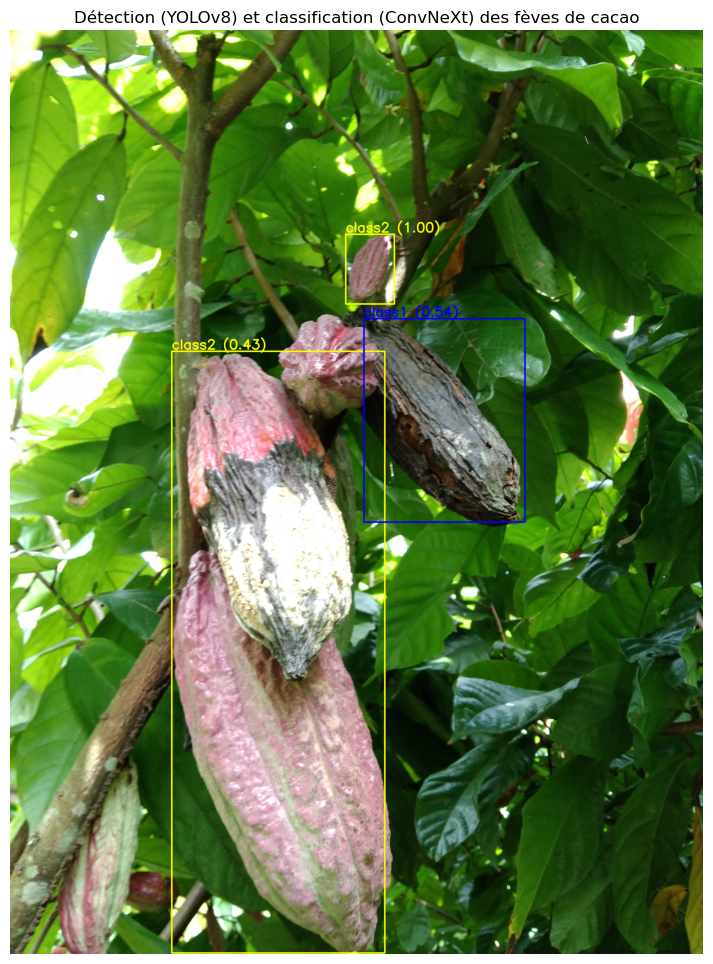

In [ ]:
img_path = "sana1.jpg"  # Remplacez par le chemin vers votre image
orig_img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

output_img = process_image(img_rgb)

# Affichage de l'image annotée avec Matplotlib
plt.figure(figsize=(12, 12))
plt.imshow(output_img)
plt.axis("off")
plt.title("Détection (YOLOv8) et classification (ConvNeXt) des fèves de cacao")

plt.show()